In [11]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML #for displaying HTML strings


In [12]:
def format_df(df, caption=''):
    """
    Format a dataframe nicely
    """
    import inspect

    #to allow full style export to Excel, user apply or applymap (using subset).
    #So I try as much as possible to avoid using html selectors: set_table_styles, set_properties, etc
    mask_numeric_columns = df.select_dtypes(include=np.number).columns.tolist()  # works like a charm
    #df.replace(r"<td>((\d)+?(.(\d)+))", r"<td class='numeric_class'>\1")
    #re.sub(r"<td>((\d)+?(.(\d)+))", r"<td class='numeric_class'>\1", df)
    #df.replace('Total', 'total_class')

    #more_search_strings = ['Max', 'Min']
    if isinstance(df.index, pd.MultiIndex):  # multi index
        # if number_levels > 1: #multi index
        msk = df.iloc[:, 0].astype(str).str.contains('Total|Max|Min') | df.index.get_level_values(0).astype(str).str.contains('Total|Max|Min')
        #msk = df.iloc[:, 0].astype(str).str.contains('Total') | df.index.get_level_values(0).astype(str).str.contains('Total')
        # for i in more_search_strings:
        #     msk = msk | df.iloc[:, 0].astype(str).str.contains(i) | df.index.get_level_values(0).astype(str).str.contains(i)
        # #msk = df.iloc[:, 0].astype(str).str.contains('Total') | df.index.get_level_values(0).astype(str).str.contains('Total') | df.iloc[:, 0].astype(str).str.contains('Max') | df.index.get_level_values(0).astype(str).str.contains('Max') | df.iloc[:, 0].astype(str).str.contains('Min') | df.index.get_level_values(0).astype(str).str.contains('Min') # get first level only
        # #msk = any([True if df.iloc[:, 0].astype(str).str.contains(i, case=False).any() else False for i in search_strings])
    else:
        msk = df.iloc[:, 0].astype(str).str.contains('Total|Max|Min') | df.index.astype(str).str.contains('Total|Max|Min')
        # msk = df.iloc[:, 0].astype(str).str.contains('Total') | df.index.astype(str).str.contains('Total')
        # for i in more_search_strings:
        #     msk = msk | df.iloc[:, 0].astype(str).str.contains(i) | df.index.astype(str).str.contains(i) # | df.iloc[:, 0].astype(str).str.contains('Max') | df.index.astype(str).str.contains('Max') | df.iloc[:, 0].astype(str).str.contains('Min') | df.index.astype(str).str.contains('Min')

    # get instances of 'Total' in first column, but after converting column to string in case it is non-str
    mask_totals = df.index[msk].tolist()
    mask_totals_inverse = df.index[~msk].tolist()

    #msk_headers = df.iloc[:, :] #.astype(str).str.contains('Total')

    df = df.style

    df.format({'Column Total':'${0:,.0f}'})
    df.format(precision=0, decimal='.', thousands=',', subset=mask_numeric_columns)
    #df.set_properties(subset=pd.IndexSlice[:, mask_numeric_columns], **{'text-align': 'right'})
    df.set_table_styles([{'selector':'td','props':[('text-align','right'), ('padding-right', '0.5em')]}], overwrite=False)

    df.set_table_styles([{'selector':'','props':[('border','4px solid grey !important')]}], overwrite=False) #outer border
    df.set_table_styles([{'selector':'td, th','props':[('vertical-align', 'top'), ('width', '100px')]}], overwrite=False)
    df.set_table_styles([{'selector':'th, .col_heading, .row_heading, .index_name', 'props':[('background-color', '#E0F5F8'), ('text-align', 'center'), ('padding-right', '0em')]}], overwrite=False)
    df.set_table_styles([{'selector':'caption','props':[('font-size', '18px'), ('color', 'red'), ('caption-side', 'top')]}], overwrite=False)

    # df.background_gradient(cmap=cm,
    #                          subset=(df.index[-1], df.select_dtypes(float).columns))

    #df.set_caption(session.get('reportFileName', '') + ' ' + caption)

    # def headers(val):
    #     return 'background-color:red;'
    # df.applymap(headers, subset=msk_headers)

    def zeros(val):
        return 'opacity: 50%; color: rgb(233, 231, 231);' if val <= 0 else 'opacity: 100%; color: black;'
    df.applymap(zeros, subset=mask_numeric_columns)

    def highlight_max(s, props=''):
        # and s is not a subtotal (not in mask_totals)
        return np.where(s == np.nanmax(s.values), props, '')
    df.apply(highlight_max, props='color:white;background-color:darkblue', axis=0, subset=pd.IndexSlice[mask_totals_inverse, mask_numeric_columns])  # exclude Totals rows
    # df.set_properties(subset=pd.IndexSlice[mask_totals, :], **{'background-color': '#E0F5F8',
    #                   'border-top': '1px solid black', 'border-bottom': '1px solid black', 'font-size': '14px', 'font-weight': 'bold', 'opacity': '100%'})

    def highlight_totals(s):
        # and s is not a subtotal (not in mask_totals)
        return  'background-color: #E0F5F8; border-top: 1px solid black; border-bottom: 1px solid black; font-size: 14px; font-weight: bold; opacity: 100%;'
    df.applymap(highlight_totals, subset=pd.IndexSlice[mask_totals, :])

    #df.background_gradient(cmap='Greens', subset=pd.IndexSlice[df['C']<50, 'C'])
    #df.background_gradient(cmap='Greens', subset=pd.IndexSlice[mask_totals, mask_numeric_columns])
    # df.format({'Sales':'${0:,.0f}'}).bar(color='Green')
    # df.background_gradient(cmap=cm, subset=(df.index[-1], df.select_dtypes(float).columns))
    #df.background_gradient(cmap='Greens')

    #styling a whole row/column
    calling_function = inspect.stack()[1][3]
    if calling_function == 'getDatabaseMonitor':
        def age_limit(s):
            #return ['background-color: red' if val > 7 else '' for val in s]
            return ['color: red' if s['Days Ago'] > 7 else ''] * len(s)

        #df.apply(age_limit, subset=['Days Ago'])
        df.apply(age_limit, axis=1)

    elif calling_function == 'getServerMonitor':
        def age_limit(s):
            #return ['background-color: red' if val > 7 else '' for val in s]
            return ['color: red' if s['Server Age'] >= 10 else ''] * len(s)

        #df.apply(age_limit, subset=['Days Ago'])
        df.apply(age_limit, axis=1)

    # def qqqqq(s):
    #     print('qqqqqqqqqqqqqqqqqqqqq', s[0], 'qq', s[1], '', s[2])
    #     #return ['background-color: red' if val > 7 else '' for val in s]
    #     #return ['background-color: red' if s[1].contains('Total') else ''] * len(s)
    #     return ['background-color: red'] * len(s)

    # #df.apply(age_limit, subset=['Days Ago'])
    # df.apply(qqqqq, axis=1)

    return df

In [13]:
def set_plot_layout(report, reports_width, reports_height=700):
    import plotly.graph_objects as go
    
    # layout setup
    report.update_yaxes(automargin=True, visible=True,
                        ticks="", showticklabels=True)
    report.update_xaxes(automargin=True, visible=True,
                        ticks="", showticklabels=True)
    # colors: ["MidnightBlue", "IndianRed", "MediumPurple", "Orange", "Crimson", "LightSeaGreen", "RoyalBlue", "LightSalmon", "DarkOrange", "MediumSlateBlue"],
    report.update_layout(template="simple_white", modebar=dict(
        orientation='h'))  # , paper_bgcolor="LightSteelBlue"
    report.update_layout(showlegend=False, coloraxis_showscale=False,
                         uniformtext_minsize=14, uniformtext_mode='hide')
    report.update_annotations(font_size=20, font_color="blue")
    report.update_layout(autosize=True, height=reports_height, width=reports_width-50,
                         margin=dict(t=30, b=0, pad=0, autoexpand=False))  # , l=0, r=0
    #report.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    #report.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    report.update_layout(
        #title="Plot Title",
        #xaxis_title="X Axis Title",
        #yaxis_title="Y Axis Title",
        #legend_title="Legend Title",
        font=dict(
            family="Courier New, monospace",
            size=9,
            color="RebeccaPurple"
        ),
        #plot_bgcolor = "red",
        shapes=[
            # unfilled rectange
            # go.layout.Shape(
            #     type='rect',
            #     xref='paper',
            #     yref='paper',
            #     x0=0,
            #     y0=-0.1,
            #     x1=1.05,
            #     y1=1,
            #     line={'width': 1, 'color': 'black'}
            # ),
            # line
            go.layout.Shape(
                type='line',
                xref='paper',
                yref='paper',
                x0=0.5,
                y0=-0.1,
                x1=0.5,
                y1=1,
                line={'width': 1, 'color': 'black'}
            ),
        ]
    )


In [14]:
def get_subplots(data):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    #from .dashboard import set_plot_layout

    # int fails to convert a sting if it has a float inside. Solution is to first convert to float
    reports_width = 700 #int(float(request.args.get('reportsWidth')))

    columns=['AUD', 'GBP', 'EUR', 'NZD', 'USD']

    report = make_subplots(rows=1, cols=4,
        specs=[ [{"type": "bar"}, None, {"type": "pie"},  {"type": "scatter"}], ],
        subplot_titles=("Plot1", "Plot2", "Plot3" , "Plot4", ),
        column_widths=[0.5, 0, 0.25, 0.25],
        print_grid=False,
        shared_xaxes=False,
        shared_yaxes=False,
        vertical_spacing=0.3,
        #horizontal_spacing=0.05,
        )

    for col in columns:
        report.add_trace(
            go.Bar(
                name='qqq',
                #y=data.values,
                y=data[col],
                x=data.index.get_level_values(0),
                #marker={'color': color1},
                text="Click to drill down",
                customdata=['groupedBar'],  # customDataCol2
            ),
            row=1, col=1
        )

    colors = ['green', 'red', 'blue', 'yellow',
              'black', 'maroon']  # set colors for slices
    #data = data.group_by()
    report.add_trace(go.Pie(
        values=data.mean(axis=0),
        labels=data.columns,
        hole=0.4,
        domain=dict(x=[0, 0.5]),
        name="",
        textinfo='label',
        sort=False,
        rotation=-90,
        marker=dict(colors=colors),
        # hoverinfo="label+percent+name",
        hoverinfo="label+percent+value+text",
        text=["Click to drill down"]*len(data.index),
        insidetextorientation='radial',
        customdata=['pieDonut1'],
    ),
        row=1, col=3
    )

    for col in columns:
        report.add_trace(
            go.Scatter(
                x=data.index,
                #y=data.values[:, 0],
                y=data[col],
                mode="markers+lines+text",
                # text=group1_count.index,
                #textposition="bottom center",
                # fill='tozeroy',
                showlegend=True,
                customdata=['groupedLine'],
            ),
            row=1, col=4
        )

    set_plot_layout(report, reports_width, reports_height=100)

    return report

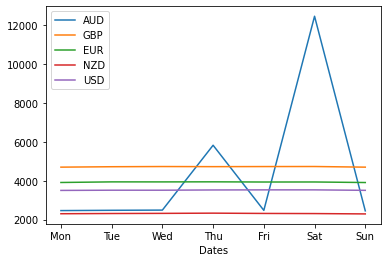

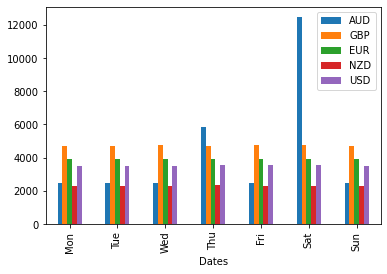

<Figure size 432x288 with 0 Axes>

In [15]:
"""
Exchange Rate Logs as a report
"""

now = datetime.now()

data = pd.read_csv('static/downloads/exchange-rates.txt', header=None)
data.columns=['AUD', 'GBP', 'EUR', 'NZD', 'USD']

data['Dates'] = data['AUD'] #.apply(lambda s: s.split(':')[0])
data.set_index('Dates', inplace=True, drop=True)
data = data.applymap(lambda s: s.split('(')[1].split(')')[0]) #(lambda s: s.str.upper().split(':')[0])

raw_data = data.copy().reset_index()
raw_data['Dates'] =  raw_data['Dates'].map(lambda s: s.split(':')[0])
raw_data = format_df(raw_data.sort_values(by=['Dates']), caption='Raw Data')

#data.index
#data = data.applymap(lambda s: s.split('(')[1].upper()) #(lambda s: s.str.upper().split(':')[0])
#data['AUD'] = data['AUD'].apply(lambda s: s.split('(')[1].split(')')[0])
#data.index = data.index.map(lambda s: s.split(':')[0][:-5]) #the -5 removes time element
data.index = data.index.map(lambda s: s.split(':')[0]) #the -5 removes time element
data.index = pd.to_datetime(data.index)
data = data.apply(pd.to_numeric)
#data.describe()
data.index.dtype
#data.columns.dtype
#data.dtypes
#data.info()

#filter data: loc, iloc or query
# The Pandas loc indexer is label-based, and can be used with DataFrames for two different use cases:
#     a.) Selecting rows by label/index
#     b.) Selecting rows with a boolean / conditional lookup
#The iloc indexer for Pandas Dataframe is used for integer-location based indexing / selection by position.

start_date = datetime(2021, 1, 28)
end_date = datetime(2023, 1, 28)
data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
# data.loc[<row selection>, <column selection>] #iloc['rorama', 'gender'], iloc[['rorama', 'user2'], ['education', 'nationality']], iloc[df['age]>30, ['name', 'age']]
# data.iloc[<row selection>, <column selection>] #integer based selection e.g. iloc[[0,1,2], 2], iloc[2:6, :], iloc[1, 3]
# data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
# data = data.loc[(data.index >= start_date) & (data.index <= end_date), ['USD', 'EUR']]
# data = data.query('Dates > "2022-01-28"')

# With a slight change of syntax, you can actually update your DataFrame in the same statement as you select and filter
# using .loc indexer. This particular pattern allows you to update values in columns depending on different conditions.
# The setting operation does not make a copy of the data frame, but edits the original data.
# # Change the first name of all rows with an ID greater than 2000 to "John"
# data.loc[data['id'] > 2000, "first_name"] = "John"
# # Change the first name of all rows with an ID greater than 2000 to "John"
# data.loc[data['id'] > 2000, "first_name"] = "John"


#raw_data = format_df(data.reset_index().sort_values(by=['Dates']), caption='Raw Data')

#duplicated and drop_duplicates
#data=data[data.duplicated(['AUD'])] #select duplicate AUD rows - except the first
#data=data[~data.duplicated()] #select non-duplicate rows - except the first
#data=data[~data.duplicated(['AUD'], keep='last')] #select non-duplicate AUD rows (drop AUD duplicates) - except the last
data=data.drop_duplicates(['AUD', 'GBP'], keep='last')

#drop rows with duplicated index (dates)
data = data[~data.index.duplicated(keep='first')]
#data.index.drop_duplicates() returns list of non-duplicated indices

#get weekday index - change index to weekday
#data['WeekDay'] = data['Dates'].apply(lambda x: x.strftime('%a'))  # weekday - A or a,  month - B or b,
data.sort_index(key=lambda x: x.weekday, ascending=True, inplace=True)
#data.sort_index(key=lambda x: x.strftime('%w'), ascending=True, inplace=True) #w is weekday as a number
data.index = data.index.strftime('%a')  # weekday - A or a,  month - B or b,

#group by index column
data = data.groupby(['Dates'], sort = False).mean()

sub_plots = get_subplots(data) #using plotly go (graph objects)

#fig = data.plot(y='AUD', kind='line') #x=data.index when not specified
#plt.scatter(data.index, data['AUD'])
fig1 = data.plot(kind='line')
fig2 = data.plot(kind='bar')

plt.show()
#print(data.shape)

data = format_df(data, caption='Processed Data') #doesnt work if there are duplicates, i.e. if rows with duplicated index (dates) were not dropped above

#aHtml = (sub_plots.to_html() + '<br/><br/>' + raw_data.to_html() + '<br/><br/>' + data.to_html() + '<br/><br/> Chart1' + fig1.to_html() + '<br/><br/> Chart2' + fig2.to_html())
#aHtml = (sub_plots.to_html() + '<br/><br/>' + raw_data.to_html() + '<br/><br/>' + data.to_html() + '<br/><br/> Chart1' + fig1.to_html() + '<br/><br/> Chart2' + fig2.to_html())

#display(HTML(aHtml))
sub_plots.show()
plt.clf() #clear
#plt.cla() #clear


In [28]:
import pandas as pd
na_values = ['None']
df_kampala = pd.read_csv('D:/Temp/kampala_calls.csv', na_values=na_values, dtype={'pin_code': str, 'src': str, 'dest': str})
df_nairobi = pd.read_csv('D:/Temp/nairobi_calls.csv', na_values=na_values, dtype={'pin_code': str, 'src': str, 'dest': str})

df_kampala['site'] = 'KAMPALA'
df_nairobi['site'] = 'NAIROBI'

df_calls = pd.concat([df_kampala, df_nairobi], keys=['KAMPALA', 'NAIROBI'])
#df_nairobi.describe(include='all')

df_users = pd.read_csv('D:/Temp/people.csv', usecols=['pin_code', 'department', 'call_limit'], na_values=na_values, dtype={'pin_code': str})
df_users.loc[df_users['department'] != 'Training', 'department'] = 'Sales'
df_users.describe(include='all')

df_raw = pd.merge(df_calls, df_users, on='pin_code')

#filtration
not_null_pin_code = df_raw['pin_code'].notna()
status_answered = df_raw['status']=='ANSWERED'
df_raw = df_raw.loc[not_null_pin_code & status_answered]

# print(df_calls['pin_code'].dtype)
# print(df_users['pin_code'].dtype)
df_raw.loc[:4, ['calldate', 'duration']]

,calldate,duration
0,2016-03-17 11:04:16,60
2,2016-03-17 12:30:16,13
4,2016-03-17 12:38:38,11


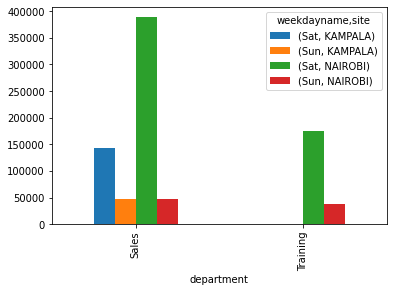

weekdayname       Sat      Sun       Sat      Sun
site          KAMPALA  KAMPALA   NAIROBI  NAIROBI
department                                       
Sales        143285.0  47259.0  389009.0  46656.0
Training          NaN      NaN  175668.0  37132.0


,id,calldate,duration,telco,country_tel_code,rate,status,site,department,call_limit,weekdayname
0,"1,513,924",2016-03-17 11:04:16,60,,78.0,264,ANSWERED,KAMPALA,Sales,"20,000",Thu
2,"1,513,941",2016-03-17 12:30:16,13,,77.0,264,ANSWERED,KAMPALA,Sales,"20,000",Thu
4,"1,513,944",2016-03-17 12:38:38,11,,70.0,298,ANSWERED,KAMPALA,Sales,"20,000",Thu
5,"1,513,945",2016-03-17 12:44:40,329,,70.0,298,ANSWERED,KAMPALA,Sales,"20,000",Thu
6,"1,513,983",2016-03-18 05:16:27,12,,41.0,175,ANSWERED,KAMPALA,Sales,"20,000",Fri
7,"1,514,036",2016-03-18 08:33:38,11,,41.0,175,ANSWERED,KAMPALA,Sales,"20,000",Fri
11,"1,514,180",2016-03-21 07:18:20,19,,41.0,175,ANSWERED,KAMPALA,Sales,"20,000",Mon
12,"1,514,190",2016-03-21 08:31:54,166,,77.0,264,ANSWERED,KAMPALA,Sales,"20,000",Mon
15,"1,514,199",2016-03-21 08:51:17,270,,80.0,0,ANSWERED,KAMPALA,Sales,"20,000",Mon
16,"1,514,286",2016-03-21 12:04:24,14,,41.0,175,ANSWERED,KAMPALA,Sales,"20,000",Mon


<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt

#probe the data
df = df_raw
df.head(10)
df.tail(10)
df['telco'].unique()

#convert column data types
#df=df.applymap(str) #convert all columns
#df['calldate'] = pd.to_datetime(df['calldate'])
#df['calldate'] = df['calldate'].astype('datetime64[ns]')
df['calldate'] = pd.to_datetime(df['calldate'], format='%Y-%m-%d %H:%M:%S')
df['country_tel_code'] = df['country_tel_code'].apply(str)

#probe the data
#df['pin_code'] =df['pin_code']
#df.describe(include='all')
#df.dtypes

#df['weekday'] = df.apply(lambda row: row['calldate'].weekday(), axis = 1)
df['weekdayname'] = df.apply(lambda row: row['calldate'].strftime('%a'), axis = 1)

#process data
weekends = df['calldate'].apply(lambda x: x.weekday()).isin([5,6])
df = df.loc[weekends] #calls made over weekends
#df = df.loc[~weekends] #calls made over weekdays

#df = df.dropna() #drop all rows with any nan column
#df['callperiod'] = df['calldate'].day
df.set_index('calldate', drop=True, inplace=True)

#df.index = df.index.day #day of month
df.index = df.index.weekday #day of week

#df = df.index.value_counts()
#df = df.groupby('calldate')['duration'].sum() #group by (index) and [column]
#df = df.groupby(['site', 'weekdayname'], sort=False)['duration'].sum() #group by (index) and [column]
#df = df.groupby(['weekdayname'], sort=False)['duration'].sum() #group by (index) and [column]
#unstack to allow 'grouped' plot
# Data is often stored in so-called “stacked” or “record” format
# The stack function “compresses” a level in the DataFrame’s columns 
df = df.groupby(['weekdayname', 'site', 'department'], sort=False)['duration'].sum().unstack(['weekdayname', 'site']) #.loc[:, 'duration']

#plot

#df.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#df.index = ['Sat', 'Sun']
#df['duration'].plot()
#df.plot(kind='pie', subplots=True)
df.plot(kind='bar', subplots=False)
#df.plot(x='weekdayname', y='duration', kind='bar', colormap='jet')
#plt.xlabel='ddddddddddddddd'
plt.show()
plt.clf() #clear
#plt.cla() #clear
#df['duration']
print(df)
df_raw_formatted = format_df(df_raw.drop(columns=['pin_code', 'src', 'dest']).fillna('').iloc[:10]) #minus 'pin_code', 'src', 'dest'
df_raw_formatted


In [30]:
# merge dfs
# join dfs
# concat dfs
# stack and unstack dfs

data0 = {'A': ['sA1','sA2','sA3','sA4'], 'B': [11,11,22,44], 'C': [111,222,333,444]}
df0 = pd.DataFrame(data0)

data1 = {'A': ['A1','A2','A3','A4'], 'B': [11,11,22,44], 'C': [111,222,333,444]}
df1 = pd.DataFrame(data1)

data2 = {'A': ['A1','A2','A3'], 'b': [11,11,22], 'c': [111,222,333]}
df2 = pd.DataFrame(data2)

df3 = pd.merge(df1, df2, on='A', how='outer')
#df3 = pd.merge(df1, df2, left_on='A', right_on='A', how='outer')
#df3 = pd.merge(df1, df2, on='A', how='inner') #inner join produces only rows that match in both dfs; right join produces complete set of records from df2 with any(??) matching records in df1
df3

#df4 = pd.concat([df0, df1], keys=['df0', 'df1'])
df4 = pd.concat({'df0': df0, 'df1': df1}) #another way to pass keys
#df4.loc['df0'] #retrieve only df0 records
df4

A   B    C
df0 0  sA1  11  111
    1  sA2  11  222
    2  sA3  22  333
    3  sA4  44  444
df1 0   A1  11  111
    1   A2  11  222
    2   A3  22  333
    3   A4  44  444

In [31]:
import numpy as np
ls1 = [[1,2,3],[4,5,6]]
ls2 = [[1,20,3],[4,50,6]]

arr1 = np.array(ls1)
# array([[1, 2, 3],
#        [4, 5, 6]])

arr2 = np.array(ls2)
# array([[ 1, 20,  3],
#        [ 4, 50,  6]])

arr3 = arr1*arr2
# array([[  1,  40,   9],
#        [ 16, 250,  36]])

type(arr3) # numpy.ndarray
arr3.ndim # 2 - the number of axes (dimensions) of the array
arr3.shape # (2, 3) - dimensions
arr3.size # 6 - total number of elements

np.zeros((3, 4)) #3 by 4 array of 0s
np.ones((3, 4)) #3 by 4 array of 1s
np.zeros(4) # one-dimensional array of 4 0s - better use np.arange

np.arange(10, 30, 5) #analogous to the Python built-in range

a = np.arange(10, 30, 5) # 1d array

b = np.arange(12).reshape(4, 3)     # 2d array - array of arrays
b
np.ones(10, dtype=np.int32).sum()

10